---
>「言葉は賢者の計算手段だ。賢者は言葉で考えるが、愚者は言葉で金もうけをする」 \
> トーマス・ホッブズ(Thomas Hobbes)
---

# CLIP(Contrastive Language-Image Pretraining)



CLIP（Contrastive Language-Image Pretraining）は、OpenAIによって開発された、画像とテキスト（言語）を共同で処理するための機械学習モデル

- テキストの説明とその対応する画像をよく理解するように設計されています。CLIPは言語と画像の両方で働くことができ、そのためには言語モデルと画像認識モデルの両方の特性を備えています。

- 幅広いタスクでゼロショット転移(タスクごとのFine-tuningを必要としない)可能な事前学習画像分類モデルである


## そもそもCLIPとは

CNNなどを学んだが、画像分類を既に1から作成することは、特に制約がない限り、精度を求めるのであれば実際の場面では既に行われなくなりつつある

CLIPの特徴は次のとおりである

- カテゴリーを利用者側で自由に設定できる自然言語教師型画像分類モデル  
データセットとして、一般的な画像と自由度が低いラベルの組み合わせで構成されておらず、画像と自由度が高い画像を説明したテキストを用いているため、ラベルに設定できるカテゴリーが限定されずカテゴリー設定の自由度が向上している

- 巨大な自然言語教師データであるWebImageTextを利用  
インターネットを利用して構築された4億組の画像と画像を説明する自由テキストのペアのデータセットを利用

- 多様なタスクに対するゼロショット転移で転用可能  
多様なタスクに対してゼロショット転移(Zero-Shot Transfer)、つまり、タスク特有のデータセットで学習をしないで事前学習データで学習したモデルを直接タスクに転用することができ、高い精度を達成できる

自然言語表現から直接学習することで、普通のラベルセットよりも拡張性が高くなり、単に学習するだけではなく、ゼロショット転移を可能にする言語表現同士の関連性も獲得することができる

## CLIPの動作原理

### データの前処理

CLIPは大量のテキストと画像データで訓練されており、テキストと画像はペアとして与えられ、各テキスト用と画像用のモデルの両方共に全てのデータを処理する

- テキストエンコーダについて、通常Transformerと呼ばれるモデルで処理さ、GPT（Generative Pretrained Transformer）やBERT（Bidirectional Encoder Representations from Transformers）と同様である

- 画像エンコーダは、通常: 画像は通常CNN（Convolutional Neural Networks）によって処理され、これはResNetやVGGなどの画像認識モデルと同様であるが、Vision Transformerを用いる例も存在する

CLIPの特徴ベクトルは、画像とテキストのそれぞれから生成され、マッチングがとられている

そのロスには、コントラスティブロス(Contrastive Loss)が用いられ、特徴ベクトルがテキストと画像が「一致」するように訓練される

- 正しいテキストと画像のペアの特徴ベクトルが近くなるように、一方で誤ったペアは遠くなるように学習する


# Contrastive Loss

Contrustive Lossは、SimCLR(A Simple Framework for Contrastive Learning of Visual Representations)やMoCo(Momentum Contrust)などで成功を収めた実績のある、対照学習(Contrastive Learning)による表現学習手法で利用される

まず、がContrastive Lossの目的は、**ネガティブなサンプル、つまり異なるサンプル同士については、その結果としての類似度を小さくすること**である

結論から言えば、Hard Contrastive Lossを利用することが重要であり、その理由について説明する


## Constrastive Lossの表現

まず、Hard Contrastive Lossの前に、一般的なContrastive Lossについて説明する

一般的なContrastive Lossは次の式で与えられる

$$L(x_i) = -log\frac{e^{s_{i,i}/\tau}}{\sum_{k \neq i}e^{s_{i,k}/\tau}+e^{s_{i,i}/\tau}}$$

ここで、$s_{i, j} = f(x_i)^Tg(s_j)$は類似度を示し、$f(\cdot)$は画像を超球面にマッピングする特徴量抽出器、$g(\cdot)$は$f$同様、memory bankやmomentum queueなどの何かしらの関数を、$\tau$は温度パラメータを表す

この時、$x_i$が$x_j$として認識される(ポジティブなサンプル同士と扱われる)確率$P_{i,j}$は、次のように定義される

$$P_{i,j} = \frac{e^{s_{i,j}/\tau}}{\sum_{k \neq i}e^{s_{i,k}/\tau}+e^{s_{i,i}/\tau}}$$

つまり、Contrastive lossは、ポジティブなサンプル同士(例えば同一の画像に異なる変換処理を行った場合)の表現は近傍に、ネガティブなサンプル同士(元となる画像が異なる場合)の表現は分離することを目的としている
- ポジティブなサンプル同士の表現の類似度$s_{i,j}(j = i)$は大きく、ネガティブなサンプル同士の表現の類似度$s_{i,j}(j \neq i)$は小さくすることを目的としている



## 勾配について

正のサンプルと負のサンプルの勾配について、

正のサンプル同士の類似度の勾配と、負のサンプル同士の類似度の勾配は次の式で与えられる


$$\frac{\partial L(x_i)}{\partial s(i,i)} = -\frac{1}{\tau}\sum_{k \neq i} P_{i,k}$$
$$\frac{\partial L(x_i)}{\partial s(i,i)} = -\frac{1}{\tau}P_{i,k}$$

これらの式から、以下のことがわかる

- 負のサンプルの勾配は$e^{s(i,j)/\tau}$に比例し、類似度$s(i,j)$と温度$\tau$の値に応じて勾配の大きさが変化する

- 正のサンプルの勾配の大きさは、すべての負のサンプルの勾配の合計と等しくなる$\sum_{k\neq i}|\frac{\partial L(x_i)}{\partial s(i,k)}|/|\frac{\partial L(s_i)}{\partial s(i,i)}| = 1$


## 温度$\tau$について

温度$\tau$は、表現の類似度が高い($s(i,k) (k \neq i)$が大きい負のサンプルに対するペナルティの強さ(勾配の大きさ)を制御する役割を果たす

### $\tau$による影響

まず、ネガティブなサンプル$x_j$に対する相対的なペナルティを表す$r_i(s_{i,j})$は次のように表現される

$$r_i(s_{i,j}) = |\frac{\partial L(x_i)}{\partial s(i,j)}||\frac{\partial L(x_i)}{\partial s(i,i)}|$$

実際に計算すると、以下の式を得る

$$r_i(s_{i,j}) = \frac{e^{s_{i,j}/\tau}}{\sum_{k \neq i}e^{s_{i,k}/\tau}}, i \neq j$$

この式において$\tau$を変化させながら$r_s$と$s_i$の関係を調べるとわかるが、温度$\tau$が小さいほど類似度が高いペアに対するペナルティが大きくなり、温度が大きいとペナルティの分布は一様となる

つまり、温度$\tau$が小さいほど、表現の類似度が高い($k \neq i$である場合で$s_{i,k}$が大きい)ネガティブなサンプルが、その他のネガティブなサンプルと比べて重視される(損失関数に強く影響する)ようになる

例えば、温度$\tau$に関する2つの特殊な場合、$\tau \rightarrow 0^+$および$\tau \rightarrow +\infty$について考察する

まず、$\tau \rightarrow 0^+$の場合、損失関数は以下のように近似できる

$$\lim_{\tau \rightarrow 0^+}L(x_i) = \lim_{\tau \rightarrow 0^+}-log\frac{e^{s_{i,i}/\tau}}{\sum_{k \neq i}e^{s_{i,k}/\tau}+e^{s_{i,i}/\tau}}\\
= \lim_{\tau \rightarrow 0^+}\frac{1}{\tau}max[s_{max}-s_{i,i}, 0]$$

この計算が示すように、$\tau$が限りなく0に近い極端な場合では、最も類似度が高いネガティブなサンプルだけが損失関数に影響するように設計されている

逆に$\tau \rightarrow +\infty$の場合は、同様に、

$$\lim_{\tau \rightarrow =\infty}-\frac{N-1}{N\tau}s_{i.i}+\frac{1}{N\tau}\sum^{k \neq i}s_{i,k} + \log{N}$$

となり、$\tau$が限りなく大きい極端な場合では、すべてのネガティブなサンプルの類似度は、大きさによってペナルティをかけられることなく損失関数に影響することがわかる


### $\tau$の本質

ネガティブなサンプルの表現の類似度を小さくすることがContrastive Lossの目的であることは述べた

したがって、$x_i, x_k$の表現の類似度$s_{i,k} (k\neq i)$が大きいとき、これらはモデルが識別に失敗している困難サンプル(ハードサンプル)であるといえる

このような困難なサンプルに対してペナルティをかけて、より損失関数に大きな影響をもたらすように設計されている

言い方を変えれば、Contrastive Lossは、Hardness-aware Lossといえる

その点において、$\tau$はContrastive LossのHardness-aware特性を制御するという重要な役割を果たしていると言える
- 実際、$\tau \rightarrow 0^+$および$\tau \rightarrow +\infty$といった極端な場合で学習を行うと、モデルは有益な情報を学ぶことができず、性能が大きく低下する
- $\tau$を適切に定めることが重要である

## Hard Contrastive Lossについて

類似度が高い困難なサンプルを重視するHardness-aware特性は、Contrastive Lossにおける重要な特性である

この特性をより直接的に実現する方法がHard Constrastive Lossである
- つまり、$s_{i,k}$が一定の閾値$s_\alpha^{(i)}$以上であるサンプルだけを考慮するようにすると、対応するハードコントラスト損失は

$$L_{hard}(x_i) = -log\frac{e^{s_{i,i}/\tau}}{\sum_{s_{i,k} \geq s_\alpha^{(i)}}e^{s_{i,k}/\tau}+e^{s_{i,i}/\tau}}$$

となる

この時の相対的ペナルティ$r_i$は、次のように求まる

$$r_i(s_{i,l}) = \frac{e^{s_{i,l}/\tau}}{\sum_{s_{i,k} \geq s_\alpha^{(i)}}e^{s_{i,k}/\tau}}, i \neq l$$

このHard Contrastive Lossは、上位$K$個のネガティブなサンプルのみを選択することで明示的にHardness-aware特性を付加する方法と、$\tau$により制御するHardness-aware特性による暗黙的な方法の両方を用いて、困難なサンプルへのペナルティ付けを行うことができる

## 埋め込み分布の一様性(Univormity)について

CLIPでは、画像とテキストを共通の埋め込みベクトル（embedding）にマッピングすることが重要である
- 共通の埋め込み空間では、関係するテキストと画像のペアが互いに近い位置にマッピングされるように設計されている

この埋め込み分布には、次の特性がある

- 埋め込みベクトルは画像やテキストの複雑な特性を捉えるため、高次元の空間として表現される
- 微妙な違いや類似性も表現できるように埋め込み空間は連続的である
- 意味的に関連するサンプルが互いに近い位置に配置され、これはContrastive Lossよって強化されている

この埋め込み分布について、その一様性(Uniformity)は、重要な特性であることが知られている

これに基づき、次の式で定義される一様性指標を用いることで調査できる

$$L_{uniformity}(f;t) = \log E_{(x,y)～P_{data}}e^{-t||f(x)-f(y)||^2_2}$$

実際の値は、論文を参照するとよいが、この値は、温度$\tau$が大きくなると、通常のContrastive Lossでは埋め込み分布の一様性が低くなるような値をとり、Hard Contrastive Lossの場合は、全体的にほぼ一定の値をとることが示されている

つまり、総じて一様性の向上に役立っていることがわかる


## 類似サンプルへの許容性(tolerance)について

同一の画像を変換して生成したサンプル同士をポジティブ、異なる画像から得られたサンプル同士をネガティブとするため、実際には類似している(潜在的には正である)サンプル同士の表現が分離されてしまうリスクがある

この問題への許容性(類似するネガティブなサンプル同士の表現を分離しない能力)を定量的に評価するため、同じクラスに属するサンプルの平均類似度をもとに、類似サンプルへの許容性の指標を次のように定める

$$T = E_{x,y～P_{data}}[f(x)^Tf(y))\cdot I_{l(x)=l(y)}]$$

ここで、$I_{l(x)=l(y)}]$は$l(x)=l(y)$のとき$1$、$l(x) \neq l(y)$のとき0となる

この指標についての通常のContrastive LossおよびHard Contrastive Lossの詳細は論文を参照するとよいが、Hard Contrastive Lossは全体として指標の数値が低下していることがわかる

しかしながら、これは一様性の増加の裏返しであり、特に温度が相対的に高い場合、一様性の低下を抑えつつ、類似サンプルへの許容性を高められる可能性がある

通常のContrastive lossにおいては、UniformityとToleranceはトレードオフの関係にある

このトレードオフの関係を回避するため、Hard Contrastive Lossは重要であり、総じて、Contrastive Lossの成功にはHardness-aware特性が重要である
- 一般にHard Contrastive Lossを導入することで性能が向上するといえる

## CLIPのモデル

CLIPに入力されるのは、画像とその内容を説明するテキストのペアがN個セットになったバッチである

この、N個のペアのバッチを与え、バッチ全体でNxN個の可能性のあるペアリングのうち、どのペアリングが実際に発生したかを予測するように訓練される

Image Encoderは、N個の画像からその特徴を表すベクトル I_1〜I_Nを、TextEncoderは、N個のテキストからその特徴を表すベクトル T_1〜T_N をとりだし、内積を計算する

2つのベクトルの内積値が大きいほど類似度が高いため、ペアであるベクトルの掛け算、I_1・T_1, I_2・T_2, I_3・T_3 , ... , I_N・T_N の値を最大化し、ペアではないベクトルの掛け算の値を最小化するように、Image EncoderとText Encoderのパラメータを学習する

- 標準的な画像モデルは画像特徴抽出器と線形分類器を共同で学習してラベルを予測するように学習する

- CLIPは画像エンコーダーとテキストエンコーダーを一緒に訓練し、バッチ内のN個の実ペアの画像とテキストのエンベッディングのコサイン類似度を最大化する一方で、不正確なペアのエンベッディングのコサイン類似度を最小化することで、画像とテキストのバッチ学習例の正しいペアリングを予測するように学習させる、つまり、マルチモーダルエンベッディング空間を学習する

CLIPは、この事前学習によって、画像からもテキストからも、その特徴を適切に表すベクトルを取得できるようになる

テスト時には、学習されたテキストエンコーダは、ターゲットデータセットのクラスの名前や説明を埋め込むことで、ゼロショットの線形分類器を合成することができる

<img src="https://class.west.sd.keio.ac.jp/dataai/text/CLIP1.jpg" width="800">

# CLIPの用途

CLIPは多くの用途で活用されている

- 画像分類  
  通常の画像分類タスクで高い性能を発揮する
- 物体検出  
  複数の物体とそのラベルを同時に認識できる
- ゼロショット学習  
  モデルにとって初見であるタスクやカテゴリに対応する
- 多言語対応  
  テキスト部分が言語モデルであるため、多言語のテキストと画像のペアも理解できる

このように、CLIPは多様なタスクに応用可能であり、画像と言語の複合的な理解が必要な場面で高い性能を発揮する

# CLIPを用いたゼロショット画像分類

8枚のサンプル画像を用いてゼロショット画像分類を実際に行う


## セットアップ

In [ ]:
# 1.pytorchバージョン変更
#! pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html #ftfy regex

# GithubからCLIPをクローニング
! git clone https://github.com/openai/CLIP.git
%cd CLIP/clip

# 3.CLIPモデルの重みをダウンロード
MODELS = {
    "RN50": "https://openaipublic.azureedge.net/clip/models/afeb0e10f9e5a86da6080e35cf09123aca3b358a0c3e3b6c78a7b63bc04b6762/RN50.pt",
    "RN101": "https://openaipublic.azureedge.net/clip/models/8fa8567bab74a42d41c5915025a8e4538c3bdbe8804a470a72f30b0d94fab599/RN101.pt",
    "RN50x4": "https://openaipublic.azureedge.net/clip/models/7e526bd135e493cef0776de27d5f42653e6b4c8bf9e0f653bb11773263205fdd/RN50x4.pt",
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
}
! wget {MODELS["ViT-B/32"]} -O model.pt

# simple_tokenizer インストール
! pip install ftfy regex
from simple_tokenizer import *
tokenizer = SimpleTokenizer()

# サンプル画像ダウンロード
! pip install --upgrade gdown
import gdown
gdown.download('https://drive.google.com/uc?id=1vcxH6JOtwh_-FoZ8SNXYlHF9qCi3YoDH', 'food_101.zip', quiet=False)
! unzip food_101.zip

Cloning into 'CLIP'...
remote: Enumerating objects: 247, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 247 (delta 0), reused 1 (delta 0), pack-reused 243
Receiving objects: 100% (247/247), 8.93 MiB | 16.18 MiB/s, done.
Resolving deltas: 100% (124/124), done.
/content/CLIP/clip
--2023-09-05 15:59:24--  https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.69, 13.107.213.69, 2620:1ec:bdf::69, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353976522 (338M) [application/octet-stream]
Saving to: ‘model.pt’

model.pt            100%[===================>] 337.58M  44.3MB/s    in 8.5s    

2023-09-05 15:59:32 (39.5 MB/s) - ‘model.pt’ saved [353976522/353976522]

     ━━

Downloading...
From: https://drive.google.com/uc?id=1vcxH6JOtwh_-FoZ8SNXYlHF9qCi3YoDH
To: /content/CLIP/clip/food_101.zip
100%|██████████| 485k/485k [00:00<00:00, 110MB/s]

Archive:  food_101.zip
  inflating: food_101/2847583.jpg    
  inflating: food_101/3415542.jpg    
  inflating: food_101/3428323.jpg    
  inflating: food_101/3483572.jpg    
  inflating: food_101/3574192.jpg    
  inflating: food_101/3627762.jpg    
  inflating: food_101/3666829.jpg    
  inflating: food_101/598436.jpg     


必要となるライブラリを導入

In [ ]:
import numpy as np
import torch

## 学習済みモデルをダウンロードして導入

In [ ]:
model = torch.jit.load("model.pt").cuda().eval()
model

RecursiveScriptModule(
  original_name=Multimodal
  (visual): RecursiveScriptModule(
    original_name=VisualTransformer
    (conv1): RecursiveScriptModule(original_name=Conv2d)
    (ln_pre): RecursiveScriptModule(original_name=LayerNorm)
    (transformer): RecursiveScriptModule(
      original_name=Transformer
      (resblocks): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=ResidualAttentionBlock
          (attn): RecursiveScriptModule(
            original_name=MultiheadAttention
            (out_proj): RecursiveScriptModule(original_name=_LinearWithBias)
          )
          (ln_1): RecursiveScriptModule(original_name=LayerNorm)
          (mlp): RecursiveScriptModule(
            original_name=Sequential
            (c_fc): RecursiveScriptModule(original_name=Linear)
            (gelu): RecursiveScriptModule(original_name=QuickGELU)
            (c_proj): RecursiveScriptModule(original_name=Linear)
          )
   

CLIPモデルについて概要を確認する
- CLIPモデルのパラメータ数は1億5千万
- CLIPモデルへ入力する画像サイズは224×224（RGB）
- CLIPモデルへ入力するテキストは77トークンまでで構成
- CLIPモデルと連携して利用する辞書は、語彙数が49408個

In [ ]:
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


## simple_tokenizer の動作を確認

テキストをトークンへ変換してみる

この場合、5文字がそれぞれ5つの数字(トークン)に変換される

In [ ]:
index = tokenizer.encode('I learn machine learning system')
print(index)

[328, 1768, 4169, 2378, 2422]


一方で、次のような場合、2文字に対してトークンが3つ消費されている

In [ ]:
index = tokenizer.encode('image segmentation')
print(index)

[2867, 10551, 9512]


これは、simple_tokenizeが、BPE(Byte Pair Encoding)と呼ばれる単語を要素に分割して変換する方法を採用しているためである

要素の組み合わせで様々な単語が表現可能になることから、語彙数を少なくすることができる
- segmentation が seg と mentation の2つの要素に分けてトークン化されている

## 動作確認に利用するサンプルデータセットについて

像分類に使用するサンプル画像は、オープンデータセットFood-101から選んだ8枚で、サイズは全て512×512である
- Food-101は、101種類の料理のカラー写真を集めたデータセットで、全部で101,000枚の画像が含まれている

ここでは、「ハンバーガー」、「寿司」、「たこ焼き」、「餃子」、「ラーメン」、「ピザ」、「スパゲッティ」、「オムレツ」を選択した

## 画像の前処理

- preprocessにより、は画像をリサイズして入力可能な224×224サイズに変更
- image_meanにより、画像の輝度平均を整える
- image_stdにより、は画像の輝度バラツキを整える

以上の処理をサンプル画像に施す

In [ ]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image
import glob

# 設定
preprocess = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])

image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()

# 前処理
images =[]
files = glob.glob('./food_101/*.jpg')
files.sort()
for file in files:
      image = preprocess(Image.open(file).convert("RGB"))
      images.append(image)

image_input = torch.tensor(np.stack(images)).cuda()
image_input -= image_mean[:, None, None]
image_input /= image_std[:, None, None]

print('image_input.shape = ', image_input.shape)

image_input.shape =  torch.Size([8, 3, 224, 224])


## テキストの前処理

今回設定する分類ラベルは、['takoyaki', 'susi', 'spagetti', 'ramen', 'pizza', 'omelette', 'humburger', 'gyoza'] 　の8つ

CLIPは、画像とテキストをペアで学習している関係上、単語だけでは上手く動作しない

そこで、あえて、「This is a photo of a ＊＊＊」という文にして判断させる
- 文頭に<|startoftext|>、文末に<|endoftext|>を加えて、辞書でトークンに変換する
- トークンが77個より少ない場合は余った部分をゼロ埋めし(padding)、トークンが77個を超える場合は切り捨てる


In [ ]:
# 分類ラベルの設定
labels = ['takoyaki', 'susi', 'spagetti', 'ramen', 'pizza', 'omelette', 'humburger', 'gyoza']

# ラベルを文の形のトークンへ変換
text_descriptions = [f"This is a photo of a {label}" for label in labels]
sot_token = tokenizer.encoder['<|startoftext|>']
eot_token = tokenizer.encoder['<|endoftext|>']
text_tokens = [[sot_token] + tokenizer.encode(desc) + [eot_token] for desc in text_descriptions]
text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)

# トークンをテンソルに変換
for i, tokens in enumerate(text_tokens):
    text_input[i, :len(tokens)] = torch.tensor(tokens)

text_input = text_input.cuda()

中身を確認すると、ゼロ埋めされているのがわかる

text_inputの正しい型は(8,77)であるが、これは先に示した通り、CLIPに入力されるのは、画像とその内容を説明するテキストのペアがN個セットになったバッチである

ここで用いる学習済みモデルでは8個の入力をペアとしてる(N=8)であるため、無理やり8個とも同じ文章にして入力している



In [ ]:
# 各データの先頭を表示
print(text_descriptions[0])
print(text_tokens[0])
print(text_input[0])
print(text_input.shape)

This is a photo of a takoyaki
[49406, 589, 533, 320, 1125, 539, 320, 648, 1313, 44677, 49407]
tensor([49406,   589,   533,   320,  1125,   539,   320,   648,  1313, 44677,
        49407,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], device='cuda:0')
torch.Size([8, 77])


## 画像とテキストのcos類似度を計算

実際にCLIPで画像の特徴ベクトルとテキストの特徴ベクトルを抽出し、COS類似度を計算する

CLIPが出力する画像の特徴ベクトル(image_features)、テキストの特徴ベクトル(text_features)とも、512次元のベクトルであり、それが8つまとまっているため、型は(8,512)となる

- model.encode_image(image_input) で、image_input からimage_features（画像の特徴ベクトル）を取り出す

- model.encode_text(text_input) で、text_input から text_features（テキストの特徴ベクトル）を取り出す

- image_features と text_features の内積の結果を100倍し、softmaxで各要素を合計1となる確率分布に変換、そのトップ5を算出

まずは、COS類似度の計算結果を確認する


In [ ]:
# CLIPモデルで画像とテキストの特徴を抽出
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

# 画像の特徴とテキストの特徴からCOS類似度を計算
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

print(image_features.shape)
print(text_features.shape)

torch.Size([8, 512])
torch.Size([8, 512])


cos類似度の計算結果text_probsは、以下のように(8, 8)のテンソルであり、画像がN枚、ラベルがK個あった場合は、(N, K)のテンソルとなる

- 行が画像、列がラベルを表し、該当画像の何列目の値が一番高い値かを見れば、この場合では分類したラベルが推定できる

In [ ]:
# COS類似度の計算結果をそのまま表示
print(text_probs)

tensor([[3.7313e-34, 1.0000e+00, 2.9912e-39, 2.7519e-25, 4.3362e-40, 3.3245e-34,
         1.3177e-40, 1.2782e-23],
        [1.0000e+00, 4.0299e-35, 3.4654e-38, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.2253e-34],
        [1.2899e-10, 1.5230e-28, 0.0000e+00, 2.6064e-43, 0.0000e+00, 1.4013e-45,
         0.0000e+00, 1.0000e+00],
        [1.9657e-27, 6.3184e-30, 1.8655e-41, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 8.3725e-37],
        [0.0000e+00, 5.9947e-33, 1.1338e-40, 0.0000e+00, 1.0000e+00, 9.7126e-29,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 5.9577e-29, 1.0000e+00, 1.5733e-34, 4.5597e-37, 1.2892e-43,
         0.0000e+00, 0.0000e+00],
        [6.2636e-23, 6.2317e-31, 1.1070e-43, 0.0000e+00, 5.9274e-27, 1.0000e+00,
         6.7491e-37, 9.2206e-12],
        [0.0000e+00, 2.3648e-22, 0.0000e+00, 5.6052e-45, 2.9698e-41, 8.8282e-44,
         1.0000e+00, 0.0000e+00]], device='cuda:0')


## 予測結果の表示

各画像の右に、COS類似度の値が高かったラベルTOP5とその度合いを表示する

問題なく推定できていることがわかる

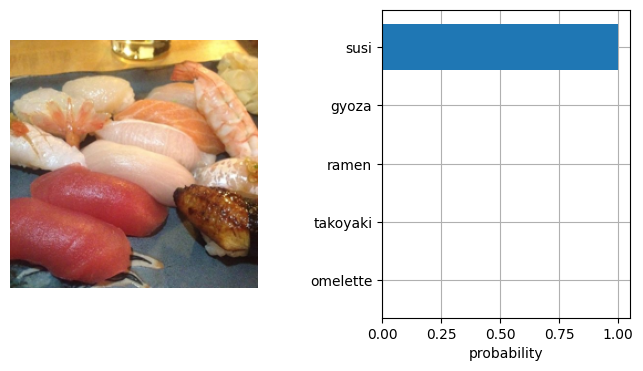

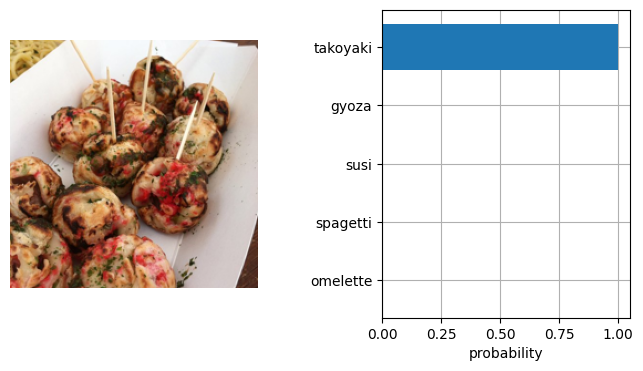

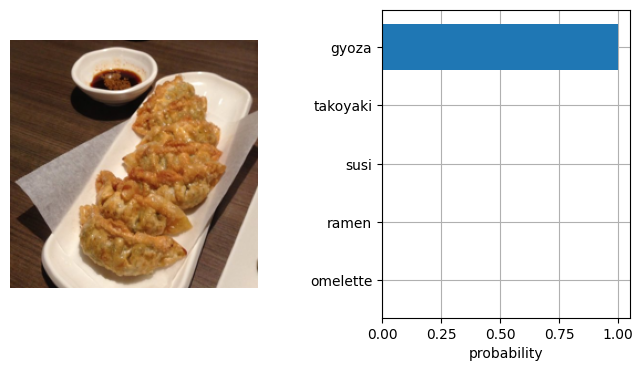

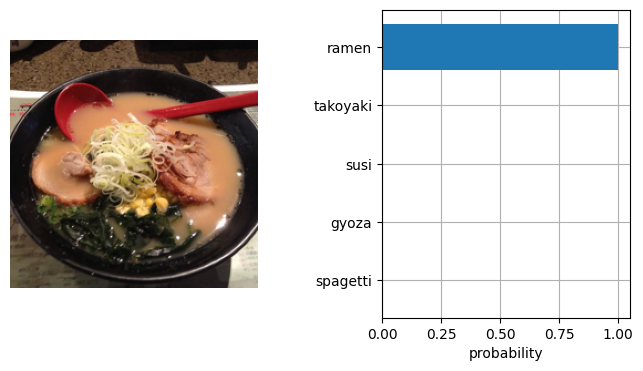

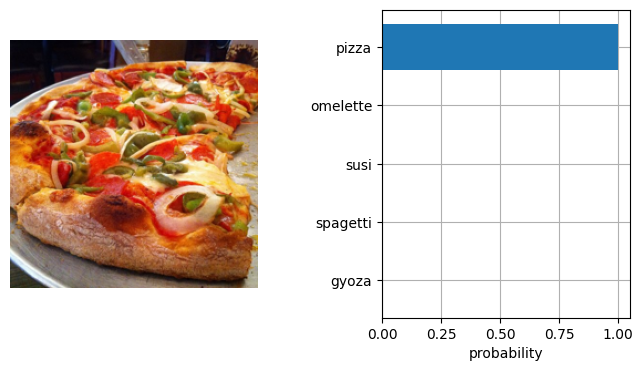

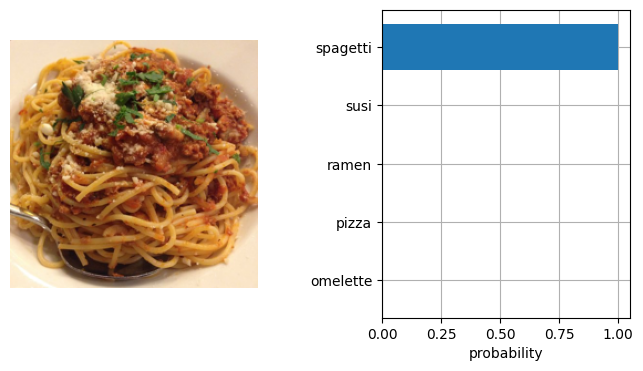

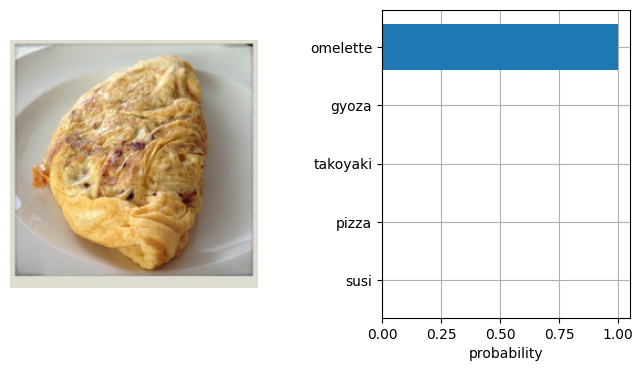

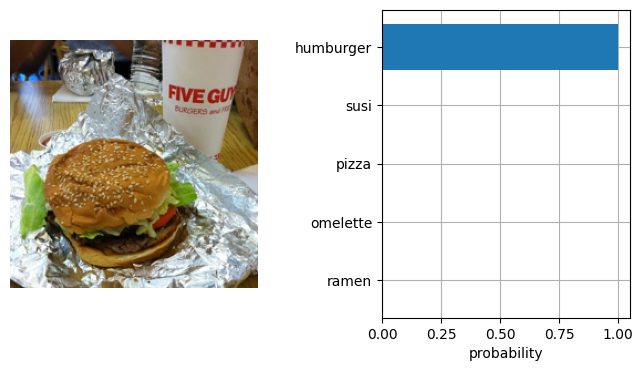

In [ ]:
import matplotlib.pyplot as plt

def pred_disp(i, image):
      plt.figure(figsize=(8, 4))
      plt.subplot(1, 2, 1)
      plt.imshow(image.permute(1, 2, 0))
      plt.axis("off")

      plt.subplot(1, 2, 2)
      y = np.arange(top_probs.shape[-1])
      plt.grid()
      plt.barh(y, top_probs[i])
      plt.gca().invert_yaxis()
      plt.gca().set_axisbelow(True)
      plt.yticks(y, [labels[index] for index in top_labels[i].numpy()])
      plt.xlabel("probability")

      plt.subplots_adjust(wspace=0.5)
      plt.show()

for i, image in enumerate(images):
     pred_disp(i, image)

# CLIPの応用事例

とにかく、CLIPは大量の応用事例がある

- 画像分類: 通常の画像分類タスク、特に限られたラベルのデータしかない場合やゼロショット学習が必要なケースで有用

- 物体検出: テキストクエリに基づいて画像内の特定の物体を識別やローカライズ

- 画像生成: テキストの指示に基づいて画像を生成する

- 画像キャプション: CLIPを逆に使って、画像からテキスト（キャプション）を生成、医療画像解析などを含めた応用が可能

- コンテンツ推薦: ユーザーが指定したテキストクエリに適した画像やビデオをレコメンド

- 検索エンジン: 画像に基づいて関連するテキストを見つけたり、テキストに基づいて関連する画像を探す

- 自動翻訳: 画像とその説明文が多言語で提供されている場合、CLIPで翻訳タスクを補助

- アートとクリエイティビティ: 作成したアート作品に適切なタイトルや説明を生成

- 監視とセキュリティ: 監視カメラの映像と、特定の事件やアクションを説明するテキストをマッピング

- ユーザーインターフェース: ユーザーが自然言語でクエリを入力し、それに最も適したアイコンやUI要素を提示するようなインターフェース

- 教育: 教材や教育的な内容を画像とともに説明する際に、CLIPを用いることで効果的な学習を提供

- Eコマース: 商品の画像と説明を照合して、顧客に更に適切な商品を推薦

などなど、産業や研究領域で新しい応用例を生まれている


## ALIEN

ALIGN(A Large-scale ImaGe and Noisy-text embedding)は、大量の画像とノイズの多いテキストデータを使った対照学習（Contrastive Learning）を行っており、CLIPと非常に似ていますが、CLIPが先に発表され、ALIGNはその後続である

ALIGNとCLIPの主な違いは次の通り

- CLIPが4億であるのに対して、ALIGNは10億を超えるノイズの多いalt-text(画像のalt属性のテキスト)を使った対照学習である

- CLIPはWikipediaの頻出単語をクエリとしてクロールするというトップダウンアプローチであるが、ALIGNは、画像のalt-textというノイズの多いデータを、高価なフィルタリングなしで使ったボトムアップアプローチである

ノイズの多いデータセットでもCLIPの手法が有効であることを示した貢献は大きい


## BigSleep

かつて、BigGANはStyleGANと双璧をなす強力なモデルであったが、クローズドな設定、つまり学習したデータの範疇に限る場合であったが、BigGANにCLIPを組み合わせたBigSleepにより、オープンになった

訓練データに含まれる特定ドメインしか生成できないという縛りが外れ、CLIPが学習している概念であれば、画像として生成できるようした

## DALL-E

OpenAIが開発、CLIPとGPT-3を組み合わせて画像を生成

DALL-Eはテキストの説明に基づいて画像を生成し、CLIPは生成された画像がテキストの指示に適しているかを評価

テキストから画像への高度なマッピングが可能

さて、このようなテキストから画像を生成するモデルは、CLIPが強力だからではなく、拡散モデルが強力だからではないのか？
- DALL-E2は拡散モデルをベースにしており、画質向上の点で大きく寄与している

- 一方で、BigSleepのようなGANベースのモデルでも、訓練データに含まれる特定ドメインの外側の生成、つまりゼロショット生成ができる

- つまり、拡散モデルとゼロショットの両方のキーパーツが揃って、高画質な画像生成が実現されている

## flamingo

ほんの一握りのアノテーションされた例を用いて、多数のタスクに迅速に適応できる視覚言語モデル（Visual Language Model, VLM）ファミリー

Flamingoは
- 強力な事前学習済みの視覚専用モデルと言語専用モデルの橋渡し
- テキストデータの任意の場所に挟み込まれた視覚データを統合したシーケンス処理
- 入力として画像やビデオをシームレスに取り込む、

などを可能としている

任意に挟み込まれたテキストと画像を含む大規模なマルチモーダルWebコーパスで学習している

## CLIPDraw

手描きスタイルの画像を生成でき、CLIPがテキストと生成された画像とを適切にマッピングする役割を果たす

CLIP は、画像エンコーダーとテキストエンコーダーから構成され、画像とテキストから同じ次元の特徴ベクトルを得ることができるため、そのCOS類似度を計算すると類似度が分かる
- これを利用して指定したテキストに最も適合した画像を求める

初期値にランダムなベジェ曲線を使い、指定されたテキストに最も一致するように、勾配降下法でこれらの曲線を徐々に調整する手法がとられている
- Image Augumentation により、作成した絵の特徴ベクトルの値を安定させている

## モデルマージ

Stable Diffusionでは、好みの絵柄を出力するためにモデルマージすることが良く行われている

CLIPにおけるモデルマージの動機はもっとプリミティブであり、CLIPのゼロショット性能と、Fine-tuningモデルの下流タスクの精度を両立させることにある

Fine-tuningを行うと、下流タスクの精度は向上するが、他の知識を忘れる現象(破滅的忘却)が広く確認されており、ゼロショットモデルがジェネラリストで、Fine-tuningがスペシャリストだとして、モデルマージによって両者のバランスを取ろうという考え方

その一つ、WISE-FTは、ゼロショットモデルとFine-tuningモデルをアンサンブルし、係数を線形平均で統合する方法を採用

- 分布シフトの精度と堅牢性のトレードオフを図ることが目的

別の例として、PAINTはWISE-FTと同様であるが、目的データの精度を向上させるために、類似したドメインのデータで訓練し、係数をアンサンブルしている点でより進んでいる
- 目的データでも精度が向上することを示している

## 事前訓練の改善

MUST(Masked Unsupervised Self-training)では、ラベルがないデータが与えられたときの「教師の源は何か」という問題に対して、自己学習(Self-training)と自己教師あり学習(Self-supervised Learning)の2つのアプローチについて提案
- 自己学習は、教師モデルと生徒モデルの2つのモデルからなるフレームワークで、教師モデルが疑似ラベルを生成し、生徒モデルがそれを基に学習
  - 自己学習は疑似ラベルに過学習しやすいという問題がある
- 自己教師あり学習は、データの一部をマスキングしたり、データ拡張を行ったりしながら、復元問題を解くようにしており、自然言語における穴埋め問題がよく利用される
  - 自己教師あり学習は下流タスクに特化したFine-tuningが必要で、ワンステップで完結しないという問題がある
- MUSTはこれら自己学習と自己教師あり学習の欠点を克服するため、疑似ラベルと生画像の2つの異なる信号を相補的に学習させて、より高精度な教師なし学習を実現している


VL-LTRでは、データセット内に多数のサンプルがあるクラスと、少数のサンプルのみをもつ多数のクラスが混在する不均衡なロングテールデータに特化した訓練方法を提案
- 従来の画像モデルだけでは不均衡データの性能が限定されるため、テキスト情報を活用して不均衡データに対処する方法を提供
- ゼロショットCLIPはある程度のロバスト性があるが、提案手法により、特に多数サンプルクラスの精度が向上

Dominoでは、機械学習モデルの性能を低下させるデータの一部(スライス)を見つけ出し、それを人間が理解しやすい形で提示することができる
- 自然画像に対するCLIP特徴量のようなクロスモーダルな埋め込みを利用し、混合ガウスモデル(クラスタリング手法)を使って性能を低下させるスライスを特定する
- この埋め込み表現は、テキスト-画像だけでなく、医用画像にはConVIRTやMIMICを使ったり、医用の時系列データにはEEGを使ったりと、自然画像のCLIP以外のさまざまなモダリティやドメインにも適用できる

## 物体検出

CLIPをはじめとするVision & Languageの技術のおかげで、オープンボキャブラリーの性能が大幅に向上した

オープンボキャブラリーでは、言語モデルを利用することで、データセットに明確に定義されていないクラスも検出できる
- クローズドな設定として、例えばCOCOのラベルでは「車」を「car」と検出するだけで、「赤い車」や「黒い車」などの特定のクラスを指定することはできなかった

CLIPを物体検出に適用することは比較的簡単で、最も直接的な方法は、スライディングウィンドウを使って画像のパッチごとにCLIPを推論させること

ViLD(Vision and Language knowledge Distillation)では、オープンボキャブラリーな分類器(CLIPやALIGN)を教師とし、物体検出器を生徒として扱い、教師と生徒は同じモデル構造とする
- 生徒側では、R-CNNで一般的なRoI-Alignを用いて、物体の候補(Proposal)を切り取る
- 切り取られた部分のEmbeddingが教師(CLIP)に近づくように学習させる
- 性能的にはそれほど優れてはいないが、基本方針を提案した点で貢献している

GLIP(Grounded Language-Image Pre-training)は物体検出と言語の関連付けを学習するモデル
- GLIPにはv1とv2の2バージョンがあり、v1は物体検出に特化したモデル、v2はマルチタスクに対応した基盤モデルとして拡張されている
- GLIPは、物体検出と言語との関連付け(グラウンディング)を統合し、物体レベルの対応や意味的な表現を学習することに特化している
- CLIPが画像とテキストの対応学習を行うのに対して、GLIPは領域(物体)とテキストの対応学習を行う


RegionCLIPでは、バックボーンから抽出されたRegion Proposalごとに、CLIP Embeddingが等しくなるようにアラインメントを調整
- 画像領域とテキストの概念を細かく調整し、物体検出の精度を向上させることができる
- RegionCLIPが明示的にCLIPのEmbeddingを学習しているのに対して、GLIPはそれにとらわれない

Detic(detector on image classification data)では、画像分類のデータを使って、物体検出の分類器を訓練するというシンプルな発想で画像分類モデルを構築
- 画像分類では、ImageNet 21Kのように、大規模かつ多クラスなデータが利用できるが、物体検出では数万クラスのデータセットが存在せず、クラスの拡張が難しい
- 画像分類のデータを使って、物体検出のクラス分類だけを行い、物体検出のタスクはRegion Proposalの切り出しまでに限定するというアイデア
  - 物体検出におけるBounding Boxの切り出しとクラス分類が密結合である必要は特に必要ないと考える
- Deticでは、クラス分類のロスをRegion Proposalかどうかの二値分類として扱うため、弱教師あり物体検出として捉えることができる

OWL-ViT(Vision Transformer for Open-World Localization)では、従来のオープンボキャブラリー物体検出手法においてRegion Proposalが必要であったのを不要とした
- Image Encoderの最後に、ViTのトークンをPoolingと射影のLinear層を追加し、画像全体のImage Embeddingを取得
- 一般的に公開されているCLIPの重みはこの状態であるが、OWL-ViTでは、PoolingとLinear層を取り除き、2つのブランチを追加
  - 分類方向では新しい射影のLinear層を、回帰方向ではMLP Headを追加し、物体検出の訓練を行う
- パッチ単位でクラスと座標を予測する
- このOWL-ViTの論文には、ここまで全ての物体検出の手法が揃っている

VL-PLM(V&L-guided Pseudo-Label Mining)は擬似ラベルベースの手法であり、Region Proposalを使用し、RoI Headを繰り返し適用することでROIの信頼度を向上させる
- Region Proposalの抽出品質が向上すれば、擬似ラベルの品質も良くなり、結果として物体検出の精度が上がる
- オープンボキャブラリー物体検出と半教師あり物体検出の両方に対応

Obj2Seqでは、物体検出とポーズ推定を同時に行うモデル
- オープンボキャブラリーではありませんが、物体検出とポーズ推定を組み合わせた点でユニークで、オブジェクトの切り出しは、Region ProposalやAnchorではなく、オブジェクトクエリとして表現されている
- モデルはTransformerベースで、Attention機構を活用しています。AttentionはQuery-Key-Valueから構成、Sequence Predictorは、オブジェクトクエリを入力として、Bounding Boxやキーポイントの座標を出力
- オブジェクトクエリの役割は、Sequence PredictorにBounding Boxやキーポイントの値を問い合わせる（クエリする）こと
  - クエリは数値表現なので、タスク固有のモデル構造は不要
  - つまり、Obj2Seqのような「物体検出とポーズ推定」を組み合わせたタスクでも、オブジェクトクエリが適切に学習できる
- Prompted Visual Indicatorにおいて、指定したカテゴリのオブジェクトに注目するように指示を与えるが、この部分CLIPに近しい
  - Region Proposalのクラス指定に近い意味を持ち、この指示自体がプロンプトとして考えられるため、プロンプトラーニングの文脈で実現できる
- Region Proposalのような力技ではなく、プロンプトラーニングやクエリを使って学習ベースで、もう少しスマートに定義している

Grounding DINOは、オープンボキャブラリー物体検出で現時点でSoTAといわれている
- 最近注目のSegment Anythingとすぐさま融合して話題
- Grounding DINOは、テキストでクラスを指定できるオープンボキャブラリー物体検出モデル
  - 本来は、Segment Anythingが通常のセグメンテーションだけでなく、オープンボキャブラリーセグメントも理論上提供可能であるが、当時は該当部分の実装が公開されていなかった
  - Grounding DINOがその未公開部分を補完する役割を果たした
- 強力な物体検出モデルであるDINOをベースに構築されており、Attentionベースである
- Image BackboneとText Backboneというユニモーダルな特徴が徐々に融合・アップデートされ、クロスモーダルな特徴を獲得していく構造を持つ
- 従来のCOCOのようなClosed-Set Detectorの情報もBounding Box予測に利用し、クローズドな情報を参照してアップデートすることでオープンボキャブラリーに応用している


## CLIPの問題点

問題の規模が大きくなり、膨大なデータセットを用いて学習することから、スケールアップには効率の向上が重要であることから、CLIPはいかに効率を向上するかを最優先に検討されている

テキストのなかの正確な単語ではなく、テキスト全体がどの画像とペアになっているかだけを予測するという、より簡単な代理タスクを解決するモデルとしている

- 細かい分類タスクが苦手である  
  自動車、花、航空機の種類など細かい分類タスクは、専用の分類器を持ち他方が精度がよい

- 抽象的で体系的なタスクが苦手である  
  画像内のオブジェクトの数を数えるような、より抽象的で体系的なタスクが苦手である

- データセットに含まれていないような新しいタスクが苦手である
  データセットに含まれないか、ほとんど現れない物体の認識が苦手であり、例えば、画像分類では初歩的なMNISTの分類精度は88％程度であるが、MNISTデータがデータセットに含まれていないためである

- 物体検出に用いるのであれば、Grounding DINOがCLIPなしで強力になったことから、CLIPの必要性が徐々に薄れている


# 課題1

各自でゼロショット画像分類器を作成しなさい

- 自分で画像を8種類以上、ラベルと共に準備する
- 実際に動作を確認する

# 課題2

## 課題2-1
ここで用いたゼロショット画像分類では、This is a photo of a という文章を構成することでCLIPに判断させている

- プロンプトエンジニアリングを参照するとよい

この文章を、意味を変えないように変更し、動作を確認しなさい

### コラム

現時点でプロンプトエンジニアリングは、ChatGPTやGPT-4を使っていかに有用な回答を引き出す方法や、Stable Diffusionを用いていかに美しい画像を生成する方法として一般的に認識されているが、その有効性は、オリジナルのCLIP論文からすでに指摘されていた

CLIPにおけるプロンプトエンジニアリングはよりプリミティブで、テンプレート構文として提供されている

単に「a photo of {class_name}」というプロンプトだけで分類するよりも、

-    a bad photo of a {class_name}.
-    a photo of many {class_name}.
-    a photo of the hard to see {class_name}.
-    ：　：

のようなテンプレート構文をText Encoderへ大量に入力し、それらのEmbeddingの平均をとって分類することで、「a photo of {class_name}」のような単純なプロンプトよりも高い分類精度が得られることが報告されている

## 課題2-2

この文章を完全に書き換えて、別のアプリケーションを構成させなさい

例えば、What foods are often eaten with the food in this photo? などとしてみるとよい



# GroundDINOを用いたZeroshot object detection

環境構築

インストール

重みのダウンロード

In [ ]:
import os
HOME = "/content"
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!pip install -q -e .
!pip install -q roboflow

CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg

%cd {HOME}/GroundingDINO

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 401, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 401 (delta 52), reused 44 (delta 44), pack-reused 324
Receiving objects: 100% (401/401), 12.84 MiB | 13.83 MiB/s, done.
Resolving deltas: 100% (205/205), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

推論

(1) ライブラリのインポート

In [ ]:
import os
import supervision as sv
from PIL import Image
import numpy as np
import cv2

import pycocotools.mask as mask_util
from groundingdino.util.inference import load_model, load_image, predict, annotate

(2)検出モデルのLoad

In [ ]:
HOME = "/content"
CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
detection_model = load_model(CONFIG_PATH, WEIGHTS_PATH)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


(3) テストデータのダウンロード

In [ ]:
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -O /content/test.jpeg

(4)推論
今回は(3)でダウンロードした写真からdogとbuildingを推論してみたいと思います。
dog

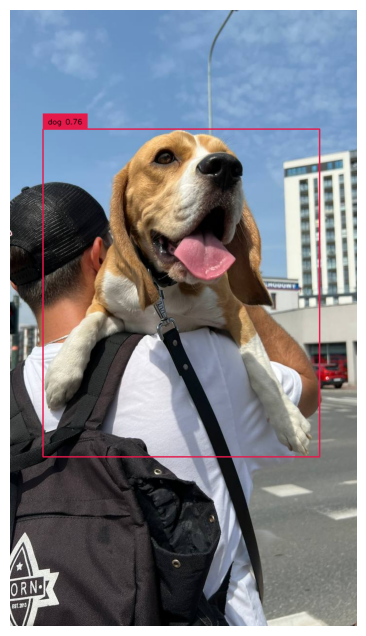

In [ ]:
IMAGE_PATH = "/content/test.jpeg"

TEXT_PROMPT = "dog"
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.3

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=detection_model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

sv.plot_image(annotated_frame, (8, 8))

building

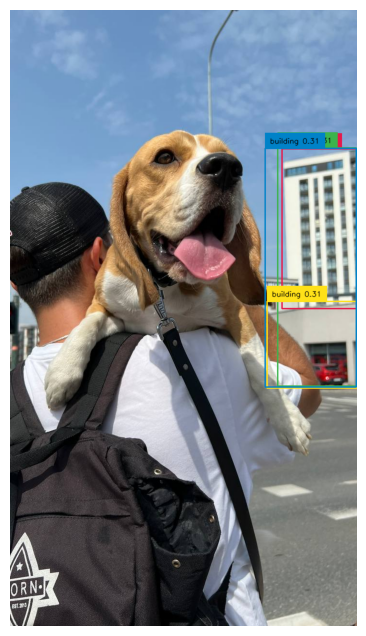

In [ ]:
IMAGE_PATH = "/content/test.jpeg"

TEXT_PROMPT = "building"  # rectangle, region, shape region, segment, fragment
BOX_TRESHOLD = 0.3  # 0.05~0.1 -> 部品点数とか図面の密度に応じている.
TEXT_TRESHOLD = 0.3  # 0.05~0.1

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=detection_model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline
sv.plot_image(annotated_frame, (8,8))

推論結果
ただテストサンプルを試しただけだと面白くないので、別のイメージについても色々と試してみましょう。同じ推論パイプラインを実行するので関数を定義しておきます

In [ ]:
def inference_pipeline(image_path, text_prompt, box_threshold=0.3, text_threshold=0.3):
  image_source, image = load_image(image_path)

  boxes, logits, phrases = predict(
      model=detection_model,
      image=image,
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )

  annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

  %matplotlib inline
  sv.plot_image(annotated_frame, (8,8))

(1)サッカー（近い）
画像の準備

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!wget https://prtimes.jp/i/1355/5420/resize/d1355-5420-149832-0.jpg -O /content/soccer.jpg

--2023-09-05 18:53:51--  https://prtimes.jp/i/1355/5420/resize/d1355-5420-149832-0.jpg
Resolving prtimes.jp (prtimes.jp)... 151.101.193.55, 151.101.65.55, 151.101.1.55, ...
Connecting to prtimes.jp (prtimes.jp)|151.101.193.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 263440 (257K) [image/jpeg]
Saving to: ‘/content/soccer.jpg’

/content/soccer.jpg 100%[===================>] 257.27K  --.-KB/s    in 0.02s   

2023-09-05 18:53:51 (12.9 MB/s) - ‘/content/soccer.jpg’ saved [263440/263440]



推論

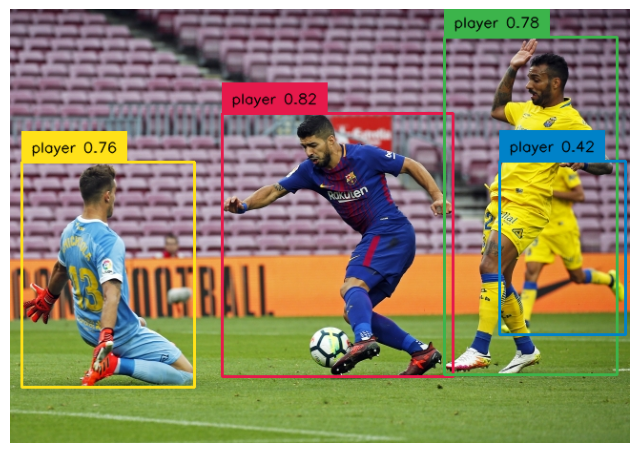

In [ ]:
inference_pipeline("/content/soccer.jpg", "player")  # player only

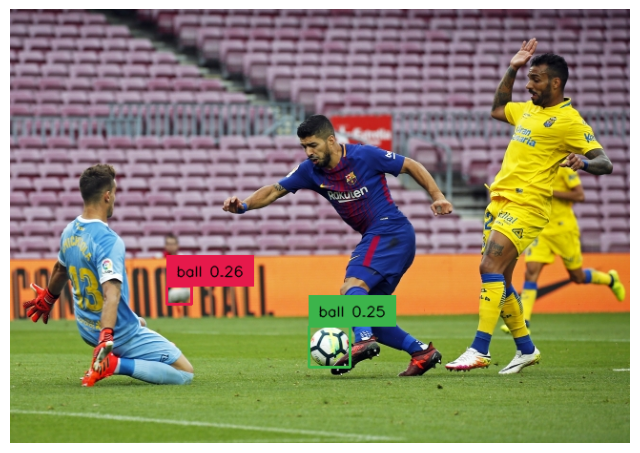

In [ ]:
inference_pipeline("/content/soccer.jpg", "ball", 0.2, 0.2)  # ball only


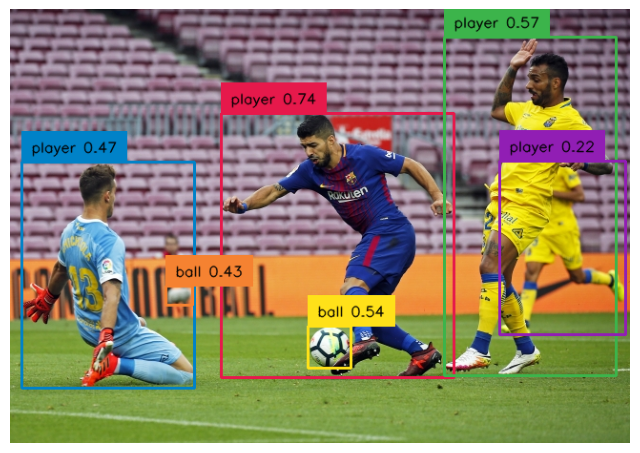

In [ ]:
inference_pipeline("/content/soccer.jpg", "player,ball", 0.2, 0.2)  # multiple outputs

# 画像とテキストのカップリング

Autoencodeでも学んだ、潜在空間で結合させるという観点では、異質なものを結合させても問題ない

これは、自動翻訳などにおいても重要な考え方である

ここでは参考として、"Text-Only Training for Image Captioning using Noise-Injected CLIP"を紹介する

## CLIPの問題点

問題の規模が大きくなり、膨大なデータセットを用いて学習することから、スケールアップには効率の向上が重要であることから、CLIPはいかに効率を向上するかを最優先に検討されている

- CNN+Transformerではなく高効率なVisionTransformerを利用
- テキストのなかの正確な単語ではなく、テキスト全体がどの画像とペアになっているかだけを予測するという、より簡単な代理タスクを解決するモデルとしている

